In [ ]:
### original code by Greg Henselman-Petrusek
### modified by Kushin Mukherjee

In [1]:
from fancyimpute import SoftImpute, BiScaler, IterativeSVD
import numpy as np
import csv
import pandas as pd
import copy
import matplotlib.pyplot as plt
import os
import seaborn as sns

from sklearn.metrics.pairwise import pairwise_distances

from scipy.io import loadmat

In [2]:
proj_dir = os.path.abspath('../../')
data_dir = os.path.join(proj_dir, 'data')


In [3]:
### read in the file ANIMALSexemplarfeaturesbig.txt as a data frame

animal_fn = os.path.join(data_dir, 'LeuvenNorms/ANIMALSexemplarfeaturesbig.txt')
animal_df = pd.read_csv(animal_fn, sep='\t', header=0, index_col=0).reset_index().drop('FFrq',axis=1)

tool_fn = os.path.join(data_dir, 'LeuvenNorms/ARTIFACTSexemplarfeaturesbig.txt')
### read in the file ARTIFACTSexemplarfeaturesbig.txt as a data frame and prevent the utf-8 encoding error
tool_df = pd.read_csv(tool_fn, sep='\t', header=0, index_col=0, encoding='latin-1').reset_index().drop('FFrq',axis=1)







In [4]:
tool_df.shape[1]+animal_df.shape[1]


297

In [52]:
animals = animal_df.columns[1:]
tools = tool_df.columns[1:]

animal_array = np.array(animal_df)[:,1:].T
tool_array = np.array(tool_df)[:,1:].T

In [53]:
full_feat_array = np.vstack([np.hstack([animal_array,np.zeros((animal_array.shape[0],tool_array.shape[1]))])\
                    ,np.hstack([np.zeros((tool_array.shape[0],animal_array.shape[1])),tool_array])]).astype(np.float)

full_feat_array[full_feat_array>0] =1 
full_concept_list = np.hstack([animals,tools])
(d1, d2) = full_feat_array.shape



distmat = pairwise_distances(full_feat_array, metric='cosine')

/var/folders/62/ybvc3cw53hj40799y980__gr0000gn/T/ipykernel_21660/3516397392.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ,np.hstack([np.zeros((tool_array.shape[0],animal_array.shape[1])),tool_array])]).astype(np.float)


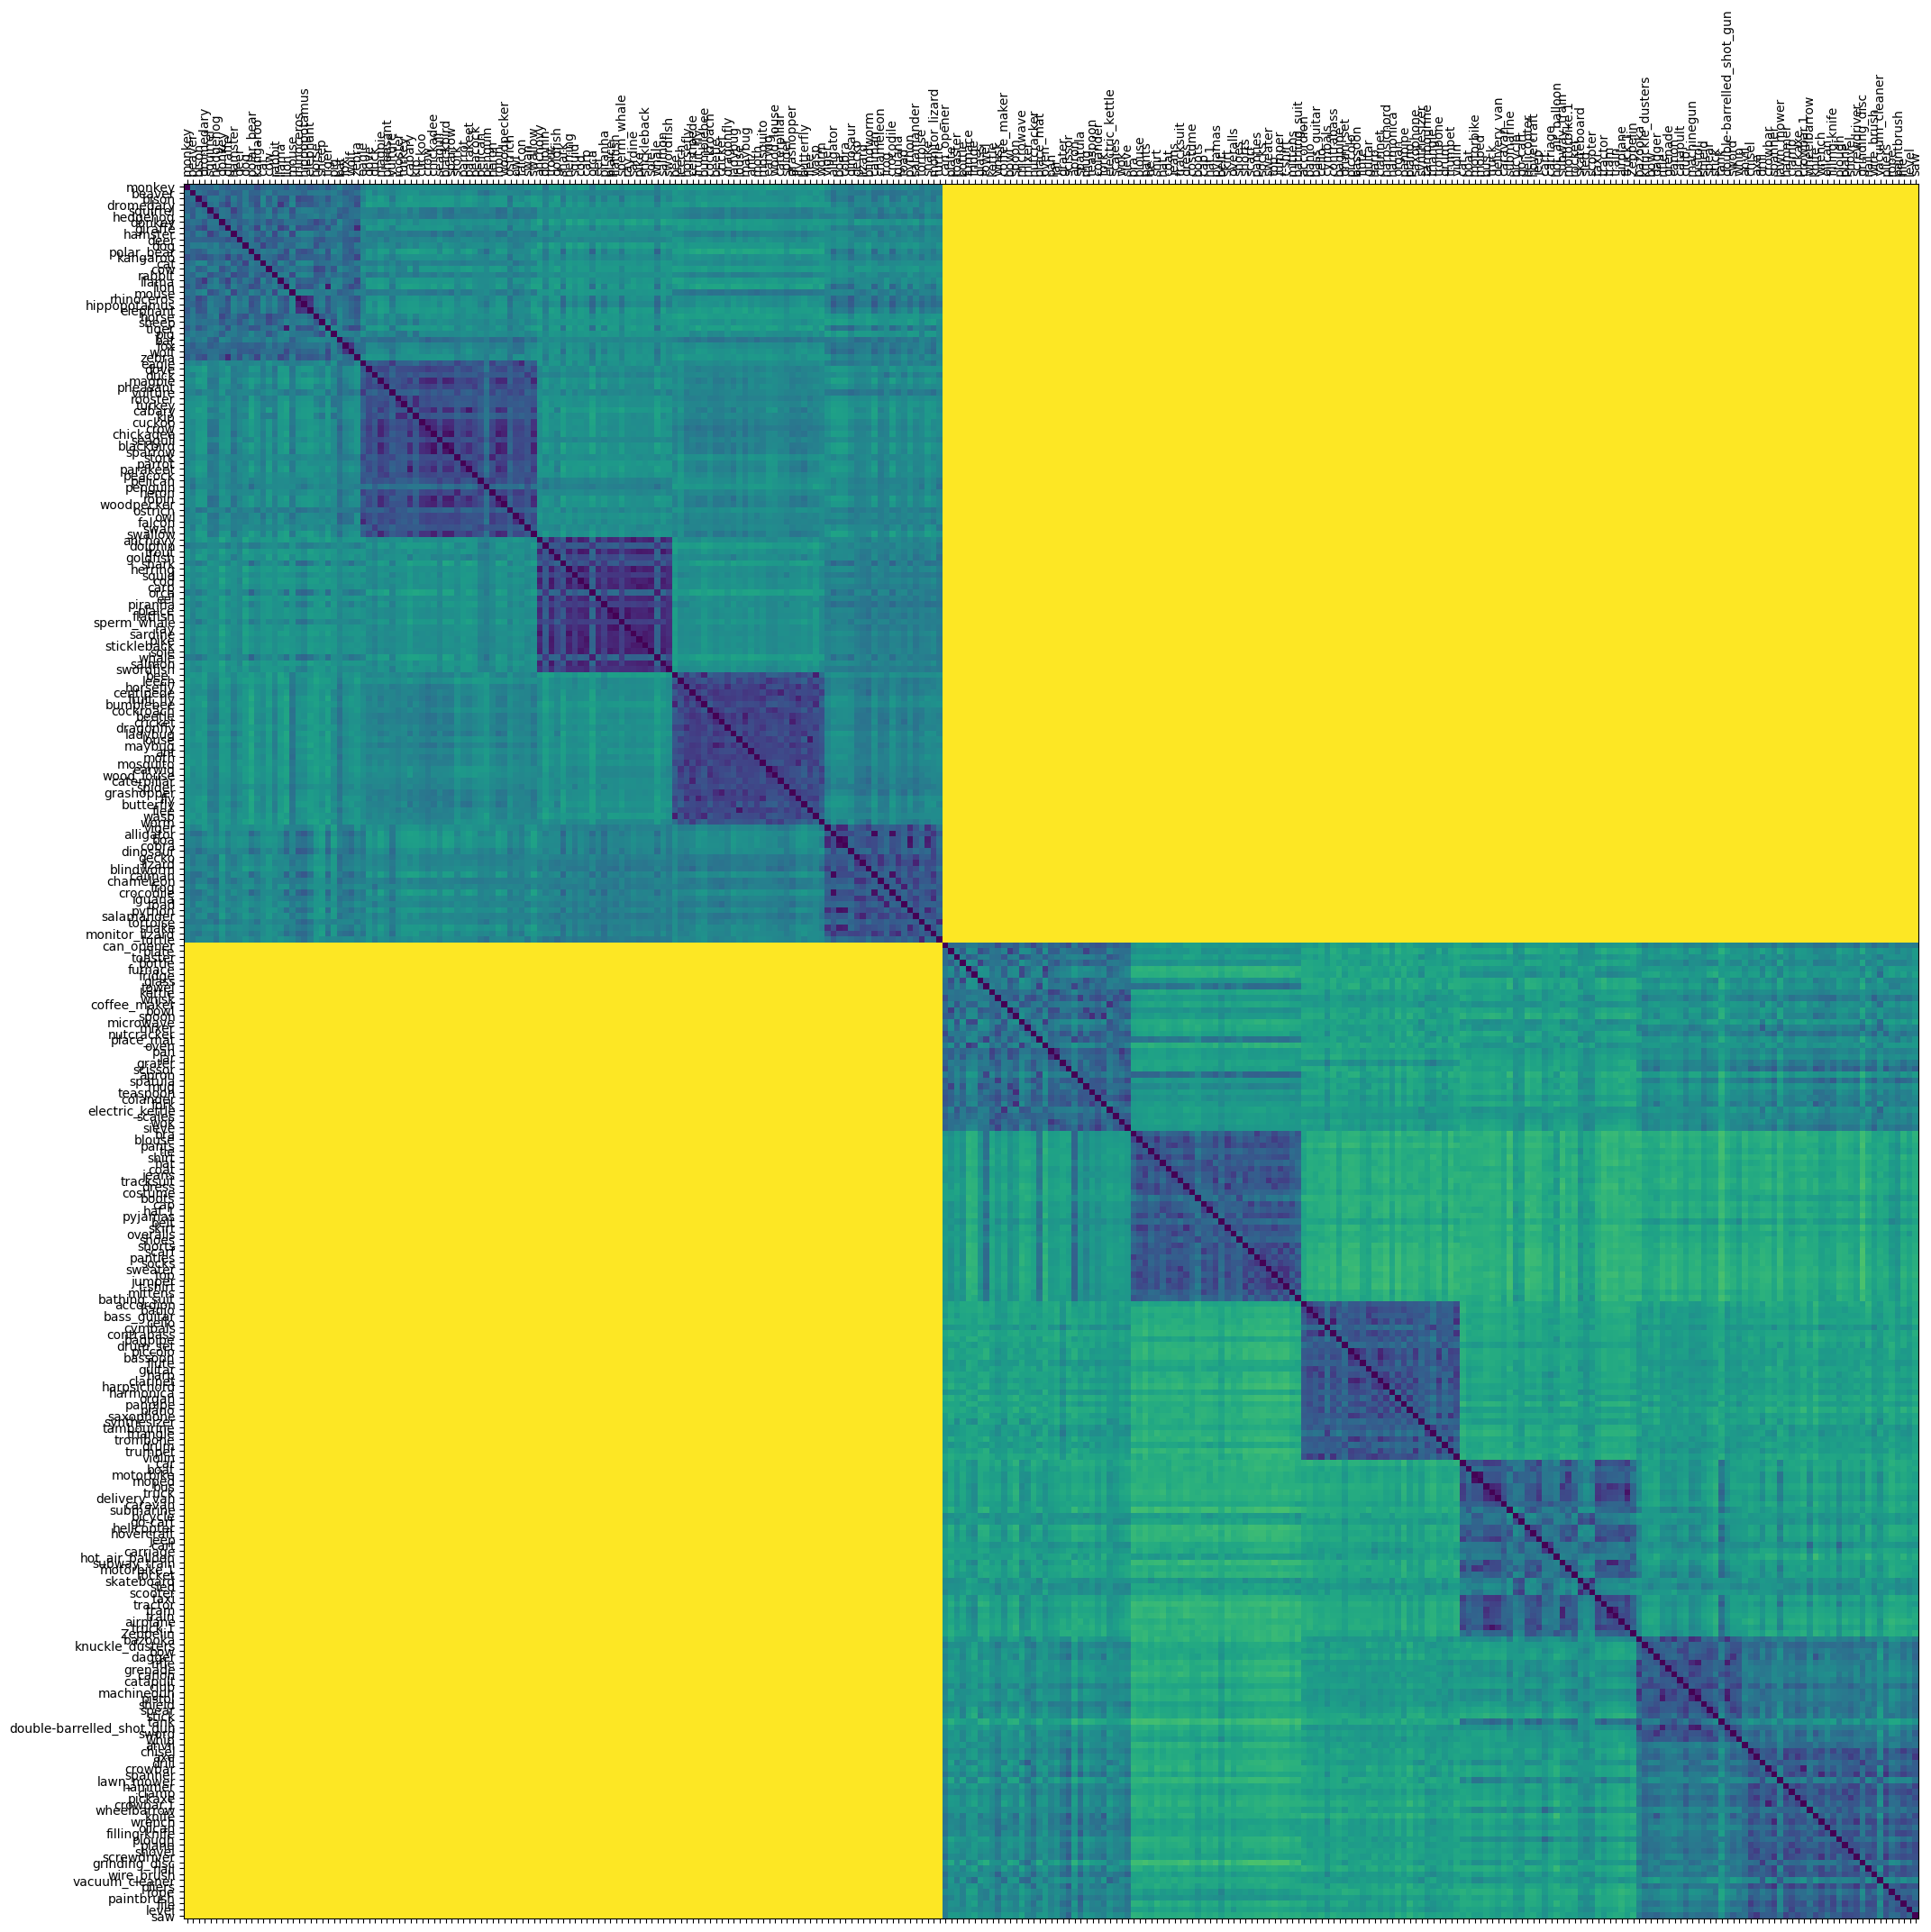

In [54]:
fig, axes = plt.subplots(1, 1, figsize=(25, 25))
axes.matshow(distmat)
### add the strings in full_concept_list as the x and y ticks
axes.set_xticks(range(len(full_concept_list)), full_concept_list, rotation=90)
axes.set_yticks(range(len(full_concept_list)), full_concept_list)
plt.show()

In [55]:
full_feat_array = full_feat_array.astype(float)
dropped_array = copy.deepcopy(full_feat_array)
dropped_positive_count = 0
dropped_negative_count = 0


#    Choose dropout parameters
#   -------------------------

p_droptruepos   =   0.5 # probability of dropping a true positive value
p_droptrueneg   =   0.5 # probability of dropping a true negative (zero) value

#   Replace some entries with NaN's
#   -------------------------------

for row in range(d1):
    for col in range(d2):
        if dropped_array[row][col] == 1:
            if np.random.uniform(0,1) < p_droptruepos:
                dropped_array[row][col] = np.NaN
                dropped_positive_count +=1
        else:
            if np.random.uniform(0, 1) < p_droptrueneg:
                dropped_array[row][col] = np.NaN
                dropped_negative_count +=1       

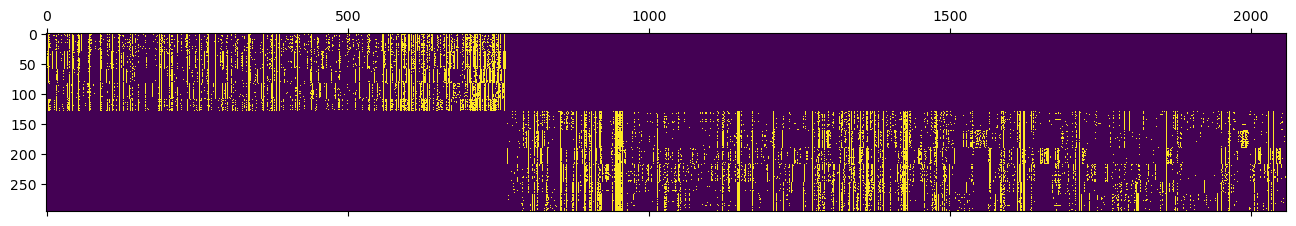

In [56]:
plt.matshow(full_feat_array)

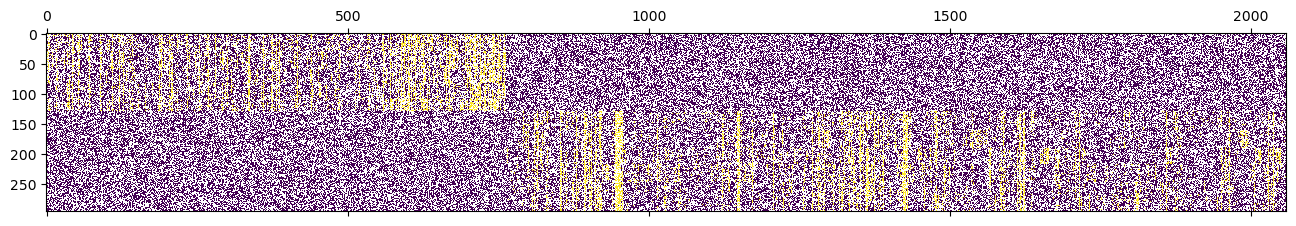

In [57]:
plt.matshow(dropped_array)

In [58]:
for iter in range(1):
    filled_array = IterativeSVD(min_value=0, max_value=1,rank=5,verbose=False).fit_transform(dropped_array)
    filled_array = np.round(filled_array)
    # X_guessed = np.round(X_filled)
    # np.clip(X_guessed, 0, 1)

    # for row in range(d1):
    #     for col in range(d2):
    #         if X_guessed[row][col] == 1:
    #             dropped_array_partfilled[row][col] = 1

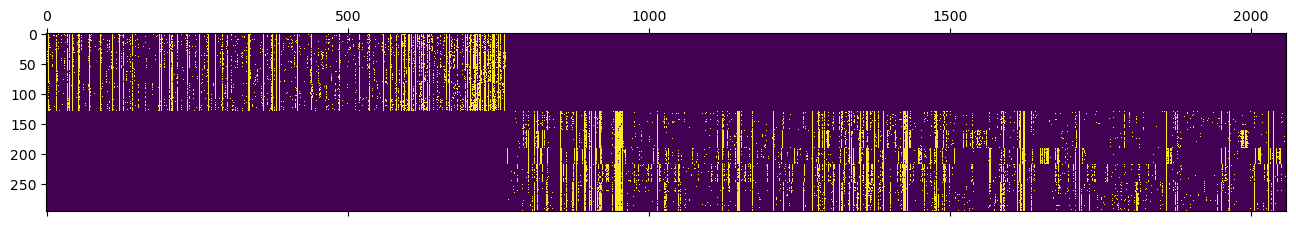

In [59]:
plt.matshow(filled_array)


In [60]:
cors=[]
for i in range(filled_array.shape[0]):
    cors.append(np.corrcoef(filled_array[i,:],full_feat_array[i,:])[0,1])

In [61]:
cors=[]
ranks=[]
noise=[]
for i in np.arange(0.1,1,step=.1):
    dropped_array = copy.deepcopy(full_feat_array)
    dropped_positive_count = 0
    dropped_negative_count = 0


    #    Choose dropout parameters
    #   -------------------------

    p_droptruepos   =   i # probability of dropping a true positive value
    p_droptrueneg   =   i # probability of dropping a true negative (zero) value


    #   Replace some entries with NaN's
    #   -------------------------------

    for row in range(d1):
        for col in range(d2):
            if dropped_array[row][col] == 1:
                if np.random.uniform(0,1) < p_droptruepos:
                    dropped_array[row][col] = np.NaN
                    dropped_positive_count +=1
            else:
                if np.random.uniform(0, 1) < p_droptrueneg:
                    dropped_array[row][col] = np.NaN
                    dropped_negative_count +=1       

    for rank in range(1,30):
        filled_array = IterativeSVD(min_value=0, max_value=1,rank=rank,verbose=False).fit_transform(dropped_array)
        filled_array = np.round(filled_array)

        for j in range(filled_array.shape[0]):
            cors.append(np.corrcoef(filled_array[j,:],full_feat_array[j,:])[0,1])
            ranks.append(rank)
            noise.append(i)

            

In [62]:
recon_df = pd.DataFrame({'corr':cors,'rank':ranks,'noise':noise})

In [63]:
recon_df

,corr,rank,noise
0,0.944705,1,0.1
1,0.918858,1,0.1
2,0.930654,1,0.1
3,0.957459,1,0.1
4,0.943881,1,0.1
...,...,...,...
76990,0.535526,29,0.9
76991,0.652316,29,0.9
76992,0.704494,29,0.9
76993,0.623427,29,0.9


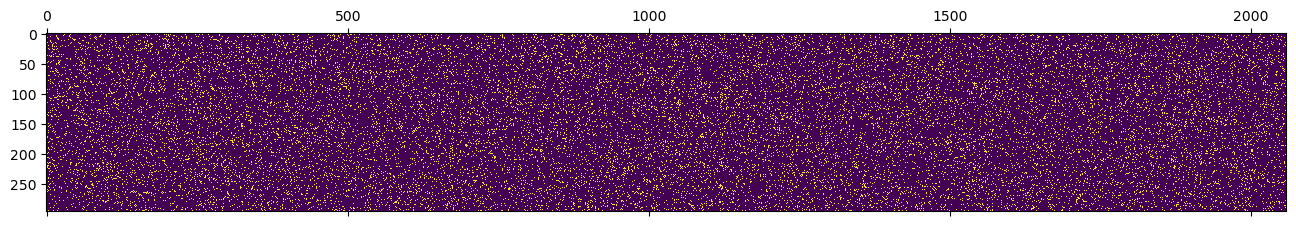

In [95]:
np.random.seed(42)
dropped_array = copy.deepcopy(full_feat_array)

## go column by column in dropped_array and shuffle the rows in each column independently then go row by row and shuffle the columns in each row independently and return a new matrix called dropped_array_shuffled
for col in range(dropped_array.shape[1]):
    dropped_array[:,col] = np.random.permutation(dropped_array[:,col])

for row in range(dropped_array.shape[0]):
    dropped_array[row,:] = np.random.permutation(dropped_array[row,:])

plt.matshow(dropped_array)

shuffled_cors=[]
shuffled_ranks=[]
for rank in range(1,30):
    u,s,v = np.linalg.svd(dropped_array, full_matrices=False)
    # s[rank:] = 0
    filled_array = u[:,:rank]@(np.diag(s[:rank])@v[:rank,:])
    filled_array = np.round(filled_array)
    for j in range(filled_array.shape[0]):
        shuffled_cors.append(np.corrcoef(filled_array[j,:],full_feat_array[j,:])[0,1])
        shuffled_ranks.append(rank)

    
   



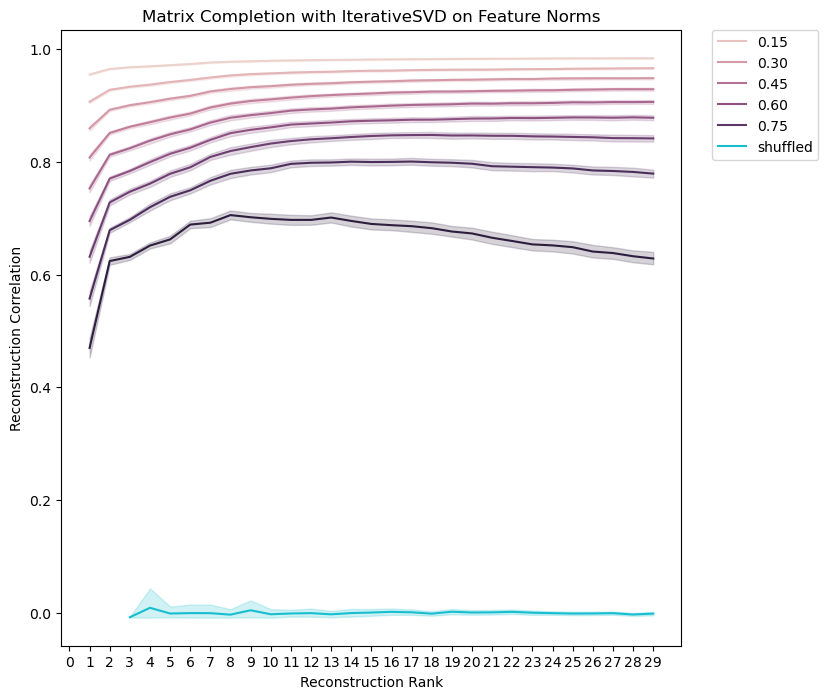

In [99]:
plt.figure(figsize=(8,8))
sns.lineplot(x='rank',y='corr',hue='noise',data=recon_df)
plt.xticks(np.arange(0,30,step=1))
#make a lineplot of the shuffled correlations
sns.lineplot(x=shuffled_ranks,y=shuffled_cors, errorbar=('ci', 95),label='shuffled')
plt.ylabel('Reconstruction Correlation')
plt.xlabel('Reconstruction Rank')
plt.legend(title='noise')
plt.title('Matrix Completion with IterativeSVD on Feature Norms')
## place legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### Greg's analyses

In [ ]:
filename="leuven_data_set_numbers_only.mat"

In [ ]:
leuven_array = loadmat(filename)
leuven_array = leuven_array['leuven_array']
leuven_array = leuven_array.astype(np.float)


In [ ]:
(d1, d2) = leuven_array.shape

dropped_array = copy.deepcopy(leuven_array)
dropped_positive_count = 0
dropped_negative_count = 0


In [ ]:
#    Choose dropout parameters
#   -------------------------

p_droptruepos   =   0.5 # probability of dropping a true positive value
p_droptrueneg   =   0.5 # probability of dropping a true negative (zero) value

#   Replace some entries with NaN's
#   -------------------------------

for row in range(d1):
    for col in range(d2):
        if dropped_array[row][col] == 1:
            if np.random.uniform(0,1) < p_droptruepos:
                dropped_array[row][col] = np.NaN
                dropped_positive_count +=1
        else:
            if np.random.uniform(0, 1) < p_droptrueneg:
                dropped_array[row][col] = np.NaN
                dropped_negative_count +=1                

#   Matrix completion with IterativeSVD
#   -----------------------------------
#       -   we apply matrix completion to the partially masked matrix; the result has real-valued entries, which we round to 0/1
#       -   you can play with the rank parameter to get different results
#       -   as Tim predicted, higher ranks seem to support recovery of rows that have a higher degree of variation
#       -   the fancyimpute library has a range of other algorithms, in addition to IterativeSVD

dropped_array_partfilled = copy.deepcopy(dropped_array)
for iter in range(1):
    X_filled = IterativeSVD(min_value=0, max_value=1,rank=20).fit_transform(dropped_array_partfilled)
    X_guessed = np.round(X_filled)
    np.clip(X_guessed, 0, 1)

    for row in range(d1):
        for col in range(d2):
            if X_guessed[row][col] == 1:
                dropped_array_partfilled[row][col] = 1

#   Evaluate performance of the reconstruction procedure
#   ----------------------------------------------------

err_count = np.sum( np.round(X_guessed) != leuven_array )
pct_error = err_count / np.prod(leuven_array.shape)
pct_nonzero_true = np.count_nonzero(leuven_array) / np.product(leuven_array.shape)
pct_pos_correctly_identified = np.count_nonzero( (X_guessed == 1) & (leuven_array ==1) )/np.count_nonzero(leuven_array ==1)
pct_pos_previously_identified = np.count_nonzero(dropped_array == 1)/np.count_nonzero(leuven_array)
err_weighted = np.sum( np.abs( np.round(X_guessed) - leuven_array) )

err_count_above = np.sum( np.abs( np.round(X_guessed) > leuven_array) )
err_count_below = np.sum( np.abs( np.round(X_guessed) < leuven_array) )
# 10258.0
# 10395.0
# 10398

print("Let K    = number of entries in the matrix")
print("Let Kt   = number of positive entries in the matrix (ground truth)")
print("Let Kf   = number of negative entries in the matrix (ground truth)")
print("------------------------------------------------------------------")
print(f"masked positives                            {dropped_positive_count}        ")
print(f"masked negatives                            {dropped_negative_count}        ")
print(f"entries guessed incorrect (num)             {err_count}                     ")
print(f"entries guessed incorrect (num/K)           {pct_error}                     ")
print(f"Kt/K                                        {pct_nonzero_true}              ")
print(f"(# correct pos guess)/Kt                    {pct_pos_correctly_identified}  ")
print(f"(# correct pos not masked)/Kt               {pct_pos_previously_identified} ")
print(f"false positives                             {err_count_above}               ")
print(f"false negatives                             {err_count_below}               ")

# EXAMPLE OUTPUT:
# Let K    = number of entries in the matrix
# Let Kt   = number of positive entries in the matrix (ground truth)
# Let Kf   = number of negative entries in the matrix (ground truth)
# ------------------------------------------------------------------
# masked positives                            3660        
# masked negatives                            384155        
# entries guessed incorrect (num)             5430                     
# entries guessed incorrect (num/K)           0.006088187906369724                     
# Kt/K                                        0.042337012033981734              
# (# correct pos guess)/Kt                    0.9819650423728814  
# (# correct pos not masked)/Kt               0.903072033898305 
# false positives                             4749               
# false negatives                             681  


fig, (ax0, ax1) = plt.subplots(nrows=2, ncols=1 )
ax0.imshow( X_guessed, cmap='tab20_r', interpolation='nearest')
ax1.imshow( leuven_array, cmap='tab20_r', interpolation='nearest')
ax0.title.set_text('leuven (reconstructed)')
ax1.title.set_text('leuven')

fig.show()
